# Generative models exercise

## Introduction

This exercise is based on a normalizing flow exercise designed by T.Quadfasel, M.Sommerhalder and S.Diefenbacher, https://github.com/uhh-pd-ml/flow-exercise

Broadly speaking the exercise is organized into three parts.
- The first part takes a look at examples some of the introduced generative models using the Two Moons data set
- The second part focuses on normalizing flows and how to build them using the nFlows package
- the third part then applies the flow methods to real physics data


## Two Moons Data Set

One common example used for benchmarking is the so-called 'two moon' dataset, consisting of two interlocking half circles. On the one hand, it tests the generative model's ability to replicate a complex structure, on the other hand, this data set also features two separate subsets, which our generative model will have to keep separate as well. 

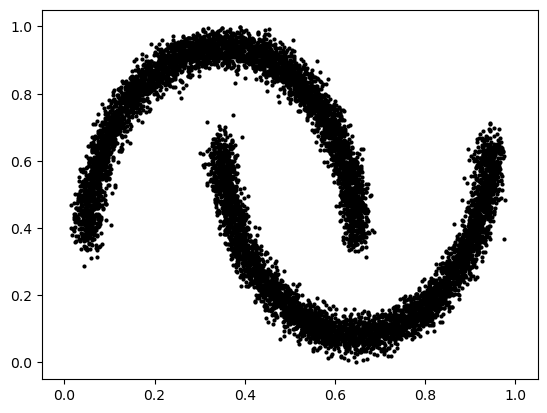

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# we will get the dataset from scikit-learn
import sklearn.datasets as datasets
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
# for two moons dataset

# define normalization function
def normalize_moons(in_data):
    max_val = np.max(in_data, keepdims=True, axis=0)
    min_val = np.min(in_data, keepdims=True, axis=0)

    new_data = (in_data-min_val)/(max_val-min_val)
    mask = np.prod(((new_data < 1) & (new_data > 0 )), axis=1, dtype=bool)
    new_data = new_data[mask]
    return new_data, mask

n = 10000
X_moons, _ = datasets.make_moons(n_samples=n, noise=.05)
X_moons, _ = normalize_moons(X_moons)

plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.savefig("./original_two_moons.pdf")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.show()
plt.close()

## PyTorch

In our next step, we import the PyTorch package, which we will be using as our machine learning backend. We also implement a generic fully connected neural network class, which we will be using in the following generative examples.

In [15]:

# our usual PyTorch functionality
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


cuda = False #torch.cuda.is_available() 
if cuda:
    device = torch.device("cuda:0")       
else:
    device = torch.device("cpu")  

# General purpose dense net
class DenseNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, activation_fn=F.relu, last_activation_fn=None):
        super(DenseNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.layers = nn.ModuleList()
        self.layers.append(torch.nn.Linear(self.input_dim, self.hidden_dim))

        for i in range(self.n_layers):
            self.layers.append(torch.nn.Linear(self.hidden_dim, self.hidden_dim))

        self.layers.append(torch.nn.Linear(self.hidden_dim, self.output_dim))
            
        self.activation_fn = activation_fn
        self.last_activation_fn = last_activation_fn
        
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation_fn(layer(x))
        x = self.layers[-1](x)
        if self.last_activation_fn is not None:
            x = self.last_activation_fn(x)
        return x



# 1.) Generative Models on Two Moons

## 1a.) Generative Adversarial Network

In [47]:
GeneratorNet = DenseNet(input_dim=8, output_dim=2, hidden_dim=16, n_layers=2).to(device)
DiscriminatorNet = DenseNet(input_dim=2, output_dim=1, hidden_dim=16, n_layers=2, last_activation_fn=F.sigmoid).to(device)

GeneratorOpt = optim.Adam(GeneratorNet.parameters(), lr=1e-4)
DiscriminatorOpt = optim.Adam(DiscriminatorNet.parameters(), lr=1e-4)

batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

BCEloss = nn.BCELoss()
for ep in range(2000):
    for i_batch in range(max_batches):

        #select the current batch from the dataset
        x_real = X_moons[i_batch*batch_size:(i_batch+1)*batch_size]
        x_real = torch.tensor(x_real, device=device).float()


        DiscriminatorOpt.zero_grad()

        with torch.no_grad():
            noise = torch.randn((batch_size, 8), device=device).float()
            x_fake = GeneratorNet(noise)

        y_real = torch.ones(batch_size, 1)
        y_fake = torch.zeros(batch_size, 1)

        y = torch.cat((y_real, y_fake), 0)
        x = torch.cat((x_real, x_fake), 0)

        Discriminator_loss = BCEloss(DiscriminatorNet(x), y)
        Discriminator_loss = Discriminator_loss.mean()
        Discriminator_loss.backward()
        DiscriminatorOpt.step()


        GeneratorOpt.zero_grad()

        noise = torch.randn((batch_size, 8), device=device).float()
        x_fake = GeneratorNet(noise)

        Generator_loss = BCEloss(DiscriminatorNet(x_fake), y_real)

        Generator_loss = Generator_loss.mean()
        Generator_loss.backward()
        GeneratorOpt.step()
    if ep%100 == 0:
        print(ep)

0


KeyboardInterrupt: 

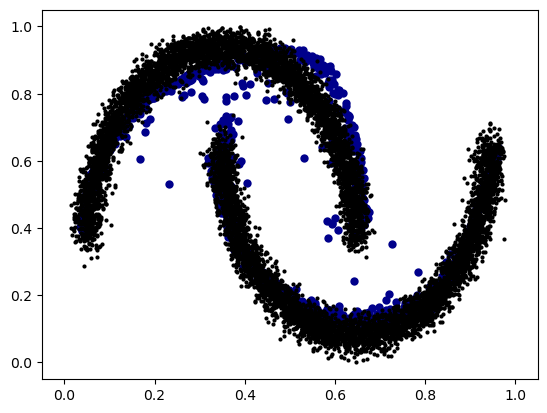

In [34]:

# Let's use the fitted distribution and sample from it
with torch.no_grad():
    noise = torch.randn((1000, 8), device=device).float()
    samples = GeneratorNet(noise).cpu().numpy()


#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

## 1b.) Variational AutoEncoder

In [53]:
EncoderNet = DenseNet(input_dim=2, output_dim=4, hidden_dim=32, n_layers=4).to(device)
DecoderNet = DenseNet(input_dim=2, output_dim=2, hidden_dim=32, n_layers=4).to(device)

EncoderOpt = optim.Adam(EncoderNet.parameters(), lr=1e-4)
DecoderOpt = optim.Adam(DecoderNet.parameters(), lr=1e-4)

batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

MSEloss = nn.MSELoss()
for ep in range(100):
    for i_batch in range(max_batches):

        EncoderOpt.zero_grad()
        DecoderOpt.zero_grad()
        
        #select the current batch from the dataset
        x_real = X_moons[i_batch*batch_size:(i_batch+1)*batch_size]
        x_real = torch.tensor(x_real, device=device).float()
        
        latent = EncoderNet(x_real)
        mu = latent[:, ::2]
        log_var = latent[:, 1::2]
        
        KLD = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        reparameterized =  eps * std + mu
        
        x_recon = DecoderNet(reparameterized)
        
        MSE = MSEloss(x_real, x_recon)
        
        loss = KLD + MSE*20
        loss.backward()

        EncoderOpt.step()
        DecoderOpt.step()

    if ep%100 == 0:
        print(ep)

0


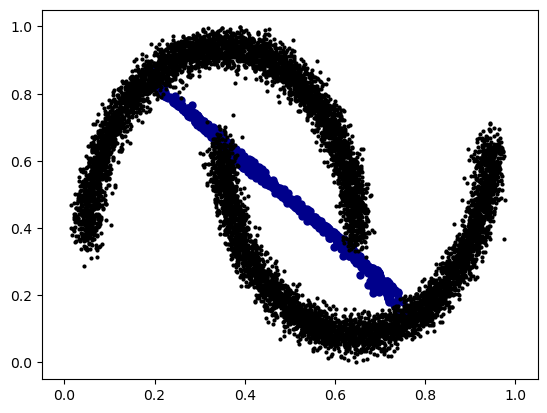

In [54]:

# Let's use the fitted distribution and sample from it
with torch.no_grad():
    noise = torch.randn((1000, 2), device=device).float()
    samples = DecoderNet(noise).cpu().numpy()


#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

# 2 Normalizing Flows

## 2a.) Motivation

Just as Variational Autoencoders (VAEs) or Generative Adversarial Networks (GANs), Normalizing Flows are **Probabilistic Generative Models (PGMs)**, which describe a probability distribution that we attempt to learn from a set of observed data. 

PGMs are useful for generating new samples from the learned distribution, evaluating the likelihood of new data points, etc. 

Normalizing flows are PGMs built on **invertible transformations**. Their advantages are that it is typically possible to efficiently **sample** and **evaluate** the learned distributions. Normalizing flows also are **highly expressive** and come with a **useful latent space representation**, since we have a one-to-one mapping between our input and the latent space. Finally, they are also **easy to train**, since we just need to conduct a simple maximum likelihood training.

In this hands-on exercise, we will show examples of using normalizing flows to estimate (conditional) probability densities and generate new samples. While some instructive mock datasets will be used for getting to know Normalizing Flows, we will also have one dedicated exercise that will use a Particle Physics dataset in the end. As a framework for actually implementing Normalizing Flows quickly, we will use the **nFlows** package. We hope this tutorial will give you at least a rough idea of how Normalizing Flows work in practice and - most importantly - that you find it instructive and fun :)

## 2b.) Normalizing Flows - The general idea (recap)

At the heart of normalizing flows stands the change of variables formula. Let's say we had a random variable $U$ and now, we apply a simple transformation, defining the transformed random variable as $X$. Then, the change of variable formula is given by:

$$ p(x) = p(u)\left| \frac{df(u)}{du}\right|^{-1} $$

As an example, let's have a look at the figure below:

<br />
<img src="https://drive.google.com/uc?id=1SoaFiiAtpYMSOepjtZkgZACQeV4Zxwbr" width="250">
<br />

We start with a uniform distribution $U$ between 0 and 1, and then do a transformation $f(U)=2\cdot U + 1$. This, however, leads to a distribution that is not normalized, so to get a proper probability distribution, we still need to scale it with $ \left| \left(\frac{df(u)}{du}\right)\right|^{-1} $.

The derivative of $f$ with respect to $u$ is 2, and the inverse is $\frac{1}{2}$, which is exactly the scaling factor that we need for getting a properly normalized distribution.

This, however, is only a simple univariate example. For the multivariate case, instead of the derivative, we need to scale our transformed distribution with the Jacobian determinant:

$$ \left|\det \left( \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right)  \right|^{-1} = \left|\det \left( \frac{\partial \boldsymbol{f}^{-1}}{\partial \boldsymbol{x}} \right)  \right| $$

The main idea of normalizing flows is to learn an invertible mapping between a very complex distribution (for example a distribution of a physics variable) and a very simple distribution. Let us consider the "generative" part first, where we attempt to generate new samples from a Normalizing Flow. In this case, we start with a simple distribution, for example, a standard Gaussian, and then repeatedly apply the random variable transformations to acquire a complex distribution similar to the input distribution that we want to approximate. Let's say we apply $k$ transformations $f_{1}...f_{k}$, starting out from a simple distribution $u_{0}$ and going to a complex distribution $u_{k}$, then the change of random variables formula becomes:

$$ p(\boldsymbol{u}_{k}) = p(\boldsymbol{u}_{0})\prod_{i} \left|\det \left( \frac{\partial \boldsymbol{f}_{i}}{\partial \boldsymbol{u}_{i-1}} \right)  \right|^{-1} $$


From this formula, we also see the reason why this method is called "normalizing flows". The random variable "flows" through a series of transformations while staying normalized by the scaling with the Jacobian determinant.

<br />
<img src="https://drive.google.com/uc?id=1fHZeW9lKGOPl7lZehy8dY0wxLVzjnQFZ" width="1000">
<br />

In a practical case, our "complex" random variables $\boldsymbol{u}_{k}$ would then approximate our input variables.

Since we choose our $\boldsymbol{f}_{i}$ to be invertible, we can also run the Normalizing Flow in the other direction, starting out with our complex input distribution and mapping this distribution to a standard Gaussian. This is the direction used for density/likelihood estimation (i.e. if you want to evaluate the likelihood of new data under the learned distribution) and also the one used for training.

For training a normalizing flow, remember that our $\boldsymbol{f}_{i}$ are actually neural networks with parameters $\theta$. We train our flow by optimizing these parameters in a negative logarithmic likelihood minimization (which is our loss function then). So we take our input samples $\boldsymbol{u}_{k}$, take it "backward" through the flow (i.e. in the direction of the blue arrows in the picture above), and then tune the parameters of our $\boldsymbol{f}_{i}$ such that the likelihood of the so transformed distribution under a standard Gaussian gets maximized.

To be able to use normalizing flows efficiently, we, therefore, need functions $f$ that are both **invertible** and **have a tractable Jacobian** that is **easy to compute**. Several methods have been proposed so far and today, you will work mainly with so-called "autoregressive flows", where the functions $f$ are chosen in a way such that the Jacobian is guaranteed to be an upper triangular matrix, so we can compute the determinant simply by multiplying its diagonal elements.


## 2c.) The nFlows package 

Today, we are going to use the PyTorch nFlows library, which is easy to set up and already contains implementations of many of the different flow models. 

Details and code of the package can be found here https://github.com/bayesiains/nflows

In [1]:


# the nflows functions what we will need in order to build our flow
from nflows.flows.base import Flow # a container that will wrap the parts that make up a normalizing flow
from nflows.distributions.normal import StandardNormal # Gaussian latent space distribution
from nflows.transforms.base import CompositeTransform # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs



Some background about the different modules:

The **flows module** contains the implementation of the actual flow models. The classes in this module already implement the functions to calculate the negative log-likelihood and the jacobian determinant.

Every flow model is defined as a series of transformations, contained in the **transformation module**. Here we will be using two different transformations, `MaskedAffineAutoregressiveTransform`, which provides the actual invertible transformation, and `ReversePermutation` which serves to permute the features within the flow. The final transformation `CompositeTransform` allows for the combining of several transformations into one module. 

Finally, the **distributions module** contains the necessary base distributions that form the latent space. In our case, we will use a gaussian latent space, defined by `StandardNormal`.





The first model we will want to look at is the Masked Autoregressive Flow (MAF) https://arxiv.org/abs/1705.07057.

The autoregressive property on a sequence of data $\boldsymbol{x} = [x_1, …, x_D]$ states that each output only depends on previous data. This means that the probability of $x_i$ is conditioned only on $x_1, ... ,x_{i-1}$. The full probability density $p(\boldsymbol{x})$ then becomes the product of the conditional densities:
$$p(\boldsymbol{x}) = \Pi_{i=1}^{D}p(x_i|x_1, …, x_{i-1})$$

An autoregressive flow makes use of this property in arranging the dependencies of the input dimensions. In each layer, the output $f_{i}(\boldsymbol{x})$ only depends on features $x_1, .. ,x_{i-1}$. The reason for this is the simpler form of the jacobian determinant. The matrix of partial derivates $\frac{\partial \boldsymbol{f}_{i}}{\partial \boldsymbol{x}_{j}}$ becomes triangular because there is no dependency between earlier input dimensions $\frac{\partial \boldsymbol{f}_{i}}{\partial \boldsymbol{x}_{j > i}} = 0$. As a result, the determinant is simply the product of diagonal elements.

The variable transformation of the MAF is a shift and scaling operation (i.e. an affine transformation):
$$z_i = x_i \exp(s_i(\boldsymbol{x})) + t_i(\boldsymbol{x})$$ 
but it chooses neural networks $\boldsymbol{s}$ and $\boldsymbol{t}$ such that they respect the autoregressive property $s_i(x_1, .., x_{i-1})$ and $t_i(x_1, .., x_{i-1})$. It achieves this by stacking so-called MADE blocks (https://arxiv.org/abs/1502.03509), which are sets of neural network layers that apply element-wise multiplications of mask matrices to the weights. The mask matrices simply contain ones and zeros, intending to turn off dependencies that would violate the autoregressive property. After each flow layer, one applies a permutation on the order of inputs.


Let's now define such a simple MAF with the nflows package. In this framework, a flow consists of a base (latent space) distribution and an invertible transformation. This flow object then has two important methods: `flow.log_prob(data)` returns the logarithmic probability of the data, `flow.sample(n_samples)` produces new data points.


In [2]:
# Fist we define the latent space distribution, in this case a choosing a 2-dim Gaussian
base_dist = StandardNormal(shape=[2])

# Now we define the series of transformation that our flow model will comprise. 
# For now we will use a singel MAF layer, we preemtivly implement this as a list,
# so to make it simple to extend. 

# For the MAF layer we need to secify the number of input parameters, as well as the 
# number of features used in the internal FCN layers. 
transforms = []
transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=4))

# Finally we can combine the list of previously defined transformations into one 
# single compisite transformation. 
transform = CompositeTransform(transforms)

# The actual flow now consist of the the base distribution and transform together
flow = Flow(transform, base_dist).to(device)

# we can then use standard PyTorch optimizers
optimizer = optim.Adam(flow.parameters())


# 2d.) Data Generation Using Flows

One major advantage of Normalizing Flow Networks is that they are inherently invertible. This means that we can not only use them for density estimation by mapping our data set to a well-known distribution like a Normal Gaussian, but we can also do the reverse, mapping the Normal Gaussian to our data distribution. This essentially allows us to generate new data by feeding Gaussian samples backward through our model. 





In [4]:
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

for i_batch in range(max_batches):

    #select the current batch from the dataset
    x = X_moons[i_batch*batch_size:(i_batch+1)*batch_size]
    x = torch.tensor(x, device=device).float()
    optimizer.zero_grad()

    #calculate negative log likelihood
    nll = -flow.log_prob(x)
    
    #update the model
    loss = nll.mean()
    loss.backward()
    optimizer.step()


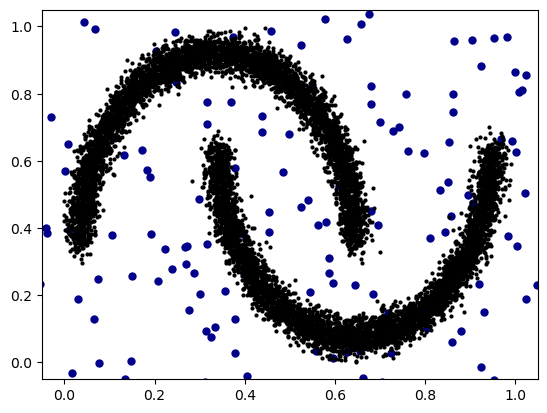

In [5]:

# Let's use the fitted distribution and sample from it
with torch.no_grad():
    samples = flow.sample(1000).cpu().numpy()


#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

In [ ]:
# Let's also plot how well our data is mapped to the Gaussian base distribution

inv = flow.transform_to_noise(torch.tensor(X_moons).float().to(device)).detach().cpu().numpy()
plt.scatter(inv[:, 0], inv[:, 1], color='black', marker='.', linewidth=0)
plt.xlabel("Transformed x1")
plt.ylabel("Transformed x2")
plt.show()
plt.close()

As we can see, our initial density is estimated rather poorly. We also see that our mapped data is far from being Gaussian distributed in the latent space. So what did we do wrong? We actually didn't use a proper flow! For getting to know nFLows, a single MAF transformation was used here. With the knowledge of how to use the module, we can now start building a powerful flow, consisting of multiple layers.

**Task: Modify the Code below to improve the generation result**

**Bonus Task: The lecture introduces Rational Quadratic Spline Flows (RQS). nFlows provides a prebuilt implementation of these transformations, which can be accessed via:**

```
MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=2, 
hidden_features=16, tail_bound = 3.0, tails = "linear"))
```

**Try replacing the MAF transformations with RQS transformations and see what effects can be observed observe.** 


# 2e.) Two Moons Generation




In [ ]:
base_dist = StandardNormal(shape=[2])

######
# Modifications here
transforms = []
transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=16))
transforms.append(ReversePermutation(features=2))
######


transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

optimizer = optim.Adam(flow.parameters())


######
# Modifications here
num_epochs = 1
batch_size = 200
######

max_batches = int(X_moons.shape[0] / batch_size)

for i in range(num_epochs):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]
    for i_batch in range(max_batches):

        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()
        optimizer.zero_grad()

        nll = -flow.log_prob(x)
        
        loss = nll.mean()
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
      print('Epoch: {:d}'.format(i))

with torch.no_grad():
  samples = flow.sample(1000).cpu().numpy()

#transform them like we did when plotting the original dataset
# samples = StandardScaler().fit_transform(samples)

#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

# 2f.) Intermediate transformation steps

So far, our implementation of normalizing flows was very effective and easy to use, however it was also rather BlackBox-y. 

The code below illustrates how one can extract the individual transformations and the base distribution from the flow model, and then perform the first `n_transforms` transformations "by hand". 

In [ ]:
# Number of transforms to perform
n_transforms = 1 

# Ensure the number of transforms to perform is lower than the total amount of transforms
n_transforms = min(len(flow._transform._transforms), n_transforms)

# Here we access the base distribution of the flow model and sample from it
z = flow._distribution.sample(1000)


with torch.no_grad():
    for i in range(1, n_transforms):
        # The flow model has an attribute called '_transform', which again has an attribute
        # '_transforms', which is a list containing the individual transforms
        # For the purpose of generating samples we need to iterate through the transforms in 
        # reverse order, hence the negative index
        m = flow._transform._transforms[-i]

        # The transforms can be applied like any other PyTorch module, however, we need 
        # to specify the direction, in the case of sampling we need the inverse. 
        # The function has two return parameters, the transformed data, and the log-determinant
        # for the sample generation we only care about the former and map the latter to a _
        z, _ = m.inverse(z)


plt.scatter(z.cpu().numpy()[:, 0], z.cpu().numpy()[:, 1], color='darkblue', marker='o', linewidth=0)
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

So far we only see the effects of the first transformation

**Task: Use the above code to plot the intermediate distributions for all flow transformations**


In [ ]:
#################
# Add code here # 
#################


## 2g.) Conditional Generative Flows

Many generative tasks in particle physics require the generative model to not only generate a random point from the data set but instead generate a point with a specific property. One example is shower simulation, where a generative shower simulator should be able to produce showers for a given particle energy, rather than just for a random one. 

This is where conditional generative models become important. In the previous example, the energy value would be the condition given to the model. 

Let us try this principle on flows with our previous two-moons data set. As one can see, it is made up of two distinct subsets, (the eponymous moons). Our conditioning will be to which moon a datapoint belongs, e.g. if we tell the model to generate points with the label 0 they should be from the top moon, while points with the label 1 should be from the bottom.

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# for two moons dataset
n = 10000
# the two moons sampling function already returns labels to which moon a data point belongs
X_moons, label_moon = datasets.make_moons(n_samples=n, noise=.05)
X_moons, mask = normalize_moons(X_moons)
label_moon = label_moon[mask]


plt.scatter(X_moons[:, 0][label_moon==0], X_moons[:, 1][label_moon==0], color='orangered', marker='.', linewidth=0)
plt.scatter(X_moons[:, 0][label_moon==1], X_moons[:, 1][label_moon==1], color='green', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./original_two_moons.pdf")
plt.show()
plt.close()

### Conditional nFlows models

Conditional models in nFlows are handled via the `context` arguments. During the definition of each transform layer, the number of conditional variables has to be specified. 

Then, during training and generation, the context has to be passed as additional input.

In [ ]:
n_features = 2
n_layers = 10
base_dist = StandardNormal(shape=[n_features])

transforms = []
for i in range(0, n_layers):
    transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=1)) # note the context_features argument
    transforms.append(ReversePermutation(features=n_features))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

optimizer = optim.Adam(flow.parameters())



num_epochs = 20
batch_size = 200

max_batches = int(X_moons.shape[0] / batch_size)

for i in range(num_epochs):
    permut = np.random.permutation(X_moons.shape[0])
    X_moons_shuffle = X_moons[permut]
    label_moon_shuffle = label_moon[permut]

    for i_batch in range(max_batches):

        x = X_moons_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()

        y = label_moon_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        y = torch.tensor(y, device=device).float().view(-1, 1)
        optimizer.zero_grad()

        nll = -flow.log_prob(x, context=y) # note the context argument
        
        loss = nll.mean()
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
      print('Epoch: {:d}'.format(i))


Now lets see how well our model performs, first by using random labels. This should look like the default two moons set. 

In [ ]:
n_samples = 10000
cond = np.random.randint(2, size=(n_samples,1))
cond = torch.tensor(cond).float().to(device)

with torch.no_grad():
  samples = flow.sample(1, context=cond).view(n_samples, -1).cpu().numpy()

print(samples.shape)

#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()


We can also test how well our conditioning performs by passing only the label 0 or only label 1 to our network. 

**Task: Complete the code below to generate points from the two moons separately, and then plot the two moons in separate colors**

**Bonus task: What happens when the flow is evaluated using labels different from 0 and 1**

In [ ]:
n_samples = 10000


######
# Modifications here
samples1 = ...
samples0 = ...

plt.scatter(samples0[:, 0], samples0[:, 1], color='orangered', marker='.', linewidth=0)
plt.scatter(samples1[:, 0], samples1[:, 1], color='green', marker='.', linewidth=0)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

# 3.) High energy physics use case

## Anomaly Detection Data Set

To illustrate the use of normalizing flows, we now want to apply it to a high energy physics example. For this aim, we use the LHCO 2020 challenge R&D dataset (https://lhco2020.github.io/homepage/). It consists of simulated QCD multijet events in addition to a signal process of a W' boson with a mass of $m_{W'} = 3.5$ TeV decaying into an X boson ($m_{X} = 500$ GeV) and a Y boson ($m_{Y} = 100$ GeV). Specifically, we use the high-level features set, which contains the 4-momenta of the two leading jets, their (1,2,3) subjettiness, and a label denoting whether the event is a signal (1) or background (0) process.

While the main purpose of this dataset was an anomaly detection competition, we will continue looking at normalizing flows from the perspective of artificial data generation. Nevertheless, if you manage to solve the advanced exercise, in the end, you will also be well prepared to understand and use the ANODE method (Anomaly Detection with Density Estimation, <a href="https://arxiv.org/abs/2001.04990">arxiv</a>).

So let's first download the dataset.

In [ ]:
%%shell
wget https://zenodo.org/record/4536377/files/events_anomalydetection_v2.features.h5

The data is stored as a pandas dataframe. We load the data and pick a random 10% subset for the sake of computation speed. Feel free to use the full data in your own time.

In [ ]:
import pandas as pd

dataset = pd.read_hdf("events_anomalydetection_v2.features.h5")
dataset = dataset.sample(frac=0.1)
print("The variables are:", [col for col in dataset.columns])

We now order the two jets by mass, such that $m_{j1} \leq m_{j2}$. Then we extract four interesting features, which could be used here to distinguish signal from background: $m_{j1}$, $m_{j2}-m_{j1}$, $\tau_{21,1}$, $\tau_{21,2}$

In [ ]:
mj1mj2=np.array(dataset[['mj1','mj2']])
tau21=np.array(dataset[['tau2j1','tau2j2']])/(1e-5+np.array(dataset[['tau1j1','tau1j2']])) # add small number to denominator to avoid division by zero
mjmin=mj1mj2[range(len(mj1mj2)),np.argmin(mj1mj2,axis=1)]
mjmax=mj1mj2[range(len(mj1mj2)),np.argmax(mj1mj2,axis=1)]
tau21min=tau21[range(len(mj1mj2)),np.argmin(mj1mj2,axis=1)]
tau21max=tau21[range(len(mj1mj2)),np.argmax(mj1mj2,axis=1)]


data = np.dstack((mjmin/1000, (mjmax-mjmin)/1000, tau21min, tau21max))[0] # put data together and convert GeV to TeV
labels = np.array(dataset['label'])
print("data.shape =", data.shape)

Let's plot these four features.

In [ ]:
## visualize the 4 extracted variables
fig, ax = plt.subplots(2,2, figsize=(12,8))
_, common_bins, _ = ax[0,0].hist(data[:,0], 100, alpha=0.6, label="data")
ax[0,0].hist(data[:,0][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[0,0].hist(data[:,0][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[0,0].set_xlabel("lower jet mass (TeV)")
ax[0,0].set_ylabel("events")
ax[0,0].set_yscale("log")
_, common_bins, _ = ax[0,1].hist(data[:,1], 100, alpha=0.6, label="data")
ax[0,1].hist(data[:,1][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[0,1].hist(data[:,1][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[0,1].set_xlabel("jet mass difference (TeV)")
ax[0,1].set_ylabel("events")
ax[0,1].set_yscale("log")
_, common_bins, _ = ax[1,0].hist(data[:,2], 100, alpha=0.6, label="data")
ax[1,0].hist(data[:,2][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[1,0].hist(data[:,2][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[1,0].set_xlabel(r"$\tau_{21,1}$")
ax[1,0].set_ylabel("events")
_, common_bins, _ = ax[1,1].hist(data[:,3], 100, alpha=0.6, label="data")
ax[1,1].hist(data[:,3][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[1,1].hist(data[:,3][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[1,1].set_xlabel(r"$\tau_{21,2}$")
ax[1,1].set_ylabel("events")
leg_handles, leg_labels = ax[0,0].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

We want train a density estimator to generate such data ourselves. We use the same MAF model as before, just reinstantiate it. This time with 4 input variables. In addition, we increase the complexity of the MADE layers in order to keep up with the more complex task.

In [ ]:
n_features = 4
n_layers = 6
base_dist = StandardNormal(shape=[n_features])

transforms = []
for i in range(0, n_layers):
    transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=128, context_features=None))
    transforms.append(ReversePermutation(features=n_features))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

optimizer = optim.Adam(flow.parameters(), lr=1e-4)

Before plugging our data into the MAF, we should preprocess the variables, so the model can learn them more easily. Density estimators tend to have difficulties with sharp edges and boundaries. We first normalize each variable to lie between 0 and 1, then we apply a logit transformation $\log(\frac{x}{1-x})$ mapping the variables to ($-\infty$, $+\infty$), and then we shift the mean to 0 and divide by the standard deviation. Here we define these three transformations, as well as their inverse functions. Be aware that for computing likelihoods, we would also need to take into account the Jacobian of each transformation. In a purely generative approach, we don't need to worry about this now.

In [ ]:
## defining variable transformations

def normalize_data(in_data, max_val, min_val):
  new_data = (in_data-min_val)/(max_val-min_val)
  mask = np.prod(((new_data < 1) & (new_data > 0 )), axis=1, dtype=bool)
  new_data = new_data[mask]
  return new_data, mask

def logit_data(in_data):
  new_data = np.log(in_data/(1-in_data))
  return new_data

def standardize_data(in_data, mean_val, std_val):
  new_data = (in_data - mean_val)/std_val
  return new_data


## defining their inverse transformations

def normalize_inverse(in_data, max_val, min_val):
  new_data = in_data*(max_val-min_val) + min_val
  return new_data

def logit_inverse(in_data):
  new_data = (1+np.exp(-in_data))**(-1)
  return new_data

def standardize_inverse(in_data, mean_val, std_val):
  new_data = std_val*in_data + mean_val
  return new_data

In [ ]:
## transform data and save max, min, mean, std values for the backtransformation later

max_values = np.max(data, keepdims=True, axis=0)
min_values = np.min(data, keepdims=True, axis=0)

## normalize
transformed_data, mask = normalize_data(data, max_values, min_values)

## logit
transformed_data = logit_data(transformed_data)

## standardize
mean_values = np.mean(transformed_data, keepdims=True, axis=0)
std_values = np.std(transformed_data, keepdims=True, axis=0)
transformed_data = standardize_data(transformed_data, mean_values, std_values)

## apply mask also to labels
transformed_labels = labels[mask]
transformed_labels = np.expand_dims(transformed_labels, -1)

Now we are ready to train the model again. Here we just train for 10 epochs (maybe even decrease it to 5 if you couldn't get a GPU). The resulting density estimate might not be perfectly optimized, but it will illustrate its power on a HEP example.

In [ ]:
num_epochs = 10
batch_size = 256

max_batches = int(transformed_data.shape[0] / batch_size)

for i in range(num_epochs):
    permut = np.random.permutation(transformed_data.shape[0])
    transformed_data_shuffle = transformed_data[permut]

    for i_batch in range(max_batches):

        x = transformed_data_shuffle[i_batch*batch_size:(i_batch+1)*batch_size]
        x = torch.tensor(x, device=device).float()

        optimizer.zero_grad()

        nll = -flow.log_prob(x)
        
        loss = nll.mean()

        loss.backward()
        optimizer.step()
    
    if i % 1 == 0:
      print('Epoch: {:d}'.format(i))


Then we sample artificial data points from this learned density. We produce the same number of datapoints that we have in our training data. Then we have to perform all the variable transformations backwards.

In [ ]:
## sample artificial data points
with torch.no_grad():
  samples = flow.sample(data.shape[0]).cpu().numpy()

## inverse standardize
retransformed_samples = standardize_inverse(samples, mean_values, std_values)

## inverse logit
retransformed_samples = logit_inverse(retransformed_samples)

## inverse normalize
retransformed_samples = normalize_inverse(retransformed_samples, max_values, min_values)

print("sampled data shape =", retransformed_samples.shape)

Let's plot the original data again and in addition the sampled data.

In [ ]:
## plot the sampled against the original data
fig, ax = plt.subplots(2,2, figsize=(12,8))
_, common_bins, _ = ax[0,0].hist(data[:,0], 100, alpha=0.6, label="data")
ax[0,0].hist(retransformed_samples[:,0], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[0,0].set_xlabel("lower jet mass (TeV)")
ax[0,0].set_ylabel("events")
ax[0,0].set_yscale("log")
_, common_bins, _ = ax[0,1].hist(data[:,1], 100, alpha=0.6, label="data")
ax[0,1].hist(retransformed_samples[:,1], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[0,1].set_xlabel("jet mass difference (TeV)")
ax[0,1].set_ylabel("events")
ax[0,1].set_yscale("log")
_, common_bins, _ = ax[1,0].hist(data[:,2], 100, alpha=0.6, label="data")
ax[1,0].hist(retransformed_samples[:,2], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[1,0].set_xlabel(r"$\tau_{21,1}$")
ax[1,0].set_ylabel("events")
_, common_bins, _ = ax[1,1].hist(data[:,3], 100, alpha=0.6, label="data")
ax[1,1].hist(retransformed_samples[:,3], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[1,1].set_xlabel(r"$\tau_{21,2}$")
ax[1,1].set_ylabel("events")
leg_handles, leg_labels = ax[0,0].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()



Even though we haven't fully trained the model, there is a striking agreement already between the original and the sampled distribution. We want to make sure now that the model has also learned the correct correlations between the four features. Let's compute the Pearson correlation coefficients and compare the two correlation matrices.



In [ ]:
import seaborn as sns

variable_labels = [r'$m_{j1}$', r'$m_{j2}-m_{j1}$', r'$\tau_{21,1}$', r'$\tau_{21,2}$']
corr_matrix_data = np.corrcoef(np.transpose(data))

corr_matrix_data = pd.DataFrame(np.corrcoef(np.transpose(data)), columns=variable_labels, index=variable_labels)
corr_matrix_sample = pd.DataFrame(np.corrcoef(np.transpose(retransformed_samples)), columns=variable_labels, index=variable_labels)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(corr_matrix_data, vmax=1., vmin=-1., cmap='coolwarm', annot=True, square=True)
plt.title("data correlations")

plt.subplot(1,2,2)
sns.heatmap(corr_matrix_sample, vmax=1., vmin=-1., cmap='coolwarm', annot=True, square=True)
plt.title("sample correlations")

plt.show()

While the comparison might still yield some room for improvement, it's clear that the normalizing flow has indeed learned the correlations between the features, rather than just sampling four independent distributions.

**Task: Use your knowledge from the previous section to train a conditional flow that can separately generate signal and background events. Sample from these separately and plot them in comparison to the actual data as before. This works best if you sample the same number of signal and background events as present in the data respectively.**

In [ ]:
######################
#Add code here
######################


## 3b.) Advanced Task

If the exercises before were too easy for you or if you would like to have an additional challenge in your own time, consider the following task. It's not rocket science but it's very likely to take more time than what we have in this exercise class.

So far, we have for the sake of simplicity only used a binary conditional variable. However, this would work just as well on a general continuous conditional. If you extracted also the dijet mass (mjj) from the dataset and plotted it. You would see that the signal peaks quite sharply at the resonance mass of 3.5 TeV. We can divide the mjj spectrum into a signal region (SR), ranging from 3.3 to 3.7 TeV, and the remaining sideband region (SB). Drawing events from the SB, you should only see very background-like distributions in the other variables, whereas the SR events should yield a very distinct signal peak in addition to the background. 

**Task: Extract and plot mjj. Train a conditional flow model with mjj as the conditional variable, then sample data from the two regions separately in the same ratio as found in the data. Plot the variables and compare them with the original data. Since this task is also more difficult for the density estimator, you might need to increase the model complexity, the number of training epochs and/or the fraction of used data to achieve a satisfying result.**

In [ ]:
######################
#Add code here
######################

